# PROJECT 1 - PART 2

## IMPORTS + DATA IMPORT

In [51]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import torch
import torch.nn as nn
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adamax

In [52]:
classes = np.array(['NORMAL', 'PNEUMONIA'])

TRAIN_RATIO = 0.80  # the rest is validation
base_path = os. getcwd() + '/datasets/chest_xray/'

def img_paths_and_labels__dirname(dirname):
    data = []
    for label in classes:
        subdir_path = os.path.join(base_path, dirname, label)
        for filename in os.listdir(subdir_path):
              data.append({ 'img_path': os.path.join(subdir_path, filename), 'label': label })
    return pd.DataFrame(data)

def img_paths_and_labels__train_val(balance_classes_by_removing_excess_data=True):
    # 1. concat the given train and validation data
    train_df = img_paths_and_labels__dirname('train')
    val_df = img_paths_and_labels__dirname('val')
    unsplit_df = pd.concat([train_df, val_df], ignore_index=True)

    # 2. make sure the new train & val have exactly 50%-50% NORMAL-PNEUMONIA
    def split_rows_of_(label):
        """take the rows that have this label, and split them into 2 (train, val)"""
        df = unsplit_df[unsplit_df['label'] == label]
        train_df, val_df = train_test_split(df, train_size=TRAIN_RATIO)
        return train_df, val_df

    train_0_df, val_0_df = split_rows_of_('NORMAL')
    train_1_df, val_1_df = split_rows_of_('PNEUMONIA')
    
    if balance_classes_by_removing_excess_data:
        len_each_train = min(map(len, [train_0_df, train_1_df]))
        train_0_df = train_0_df.iloc[: len_each_train]
        train_1_df = train_1_df.iloc[: len_each_train]

        len_each_val = min(map(len, [val_0_df, val_1_df]))
        val_0_df = val_0_df.iloc[: len_each_val]
        val_1_df = val_1_df.iloc[: len_each_val]

    train_df = pd.concat([train_0_df, train_1_df], ignore_index=True)
    val_df = pd.concat([val_0_df, val_1_df], ignore_index=True)

    # 3. shuffle each split (currently all "normal"s are at front)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    val_df = val_df.sample(frac=1).reset_index(drop=True)

    return train_df, val_df


train_df, val_df = img_paths_and_labels__train_val()

test_df = img_paths_and_labels__dirname('test')


print(train_df)


    

                                               img_path      label
0     /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
1     /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
2     /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
3     /home/ilboglions/Documents/Project1_ML4HC_Grou...     NORMAL
4     /home/ilboglions/Documents/Project1_ML4HC_Grou...     NORMAL
...                                                 ...        ...
2153  /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
2154  /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
2155  /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
2156  /home/ilboglions/Documents/Project1_ML4HC_Grou...  PNEUMONIA
2157  /home/ilboglions/Documents/Project1_ML4HC_Grou...     NORMAL

[2158 rows x 2 columns]


## 1 - Q1 Exploratory Data Analysis

## 2 - Q2 CNN Classifier

Based mainly on https://www.kaggle.com/code/nitsanbh/lungs-x-ray

In [53]:


IMAGE_DIMENSIONS = (224, 200)  # original aspect ratio is ~1.124
BATCH_SIZE = 64


def rescale_and_augment():
    return ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='constant',
        brightness_range=[0.8, 1.2],
    )


def just_rescale():
    return ImageDataGenerator(rescale=1.0/255)


def data_generator(gen_func, df, shuffle=True):
    gen = gen_func().flow_from_dataframe(
        dataframe=df,
        x_col='img_path',
        y_col='label',
        target_size=IMAGE_DIMENSIONS,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        color_mode='grayscale',
        shuffle=shuffle,
    )
    while True:
        for x_batch, y_batch in gen:
            weights = class_weights[y_batch.astype(np.int8)]
            yield x_batch, y_batch, weights


def batch_steps(df):
    return int(np.ceil(len(df) / BATCH_SIZE))


train_data = data_generator(rescale_and_augment, train_df)
validation_data = data_generator(just_rescale, val_df)
test_data = data_generator(just_rescale, test_df, shuffle=False)



In [54]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=classes, y=train_df['label'])

class_weights

array([1., 1.])

Found 16 images belonging to 2 classes.


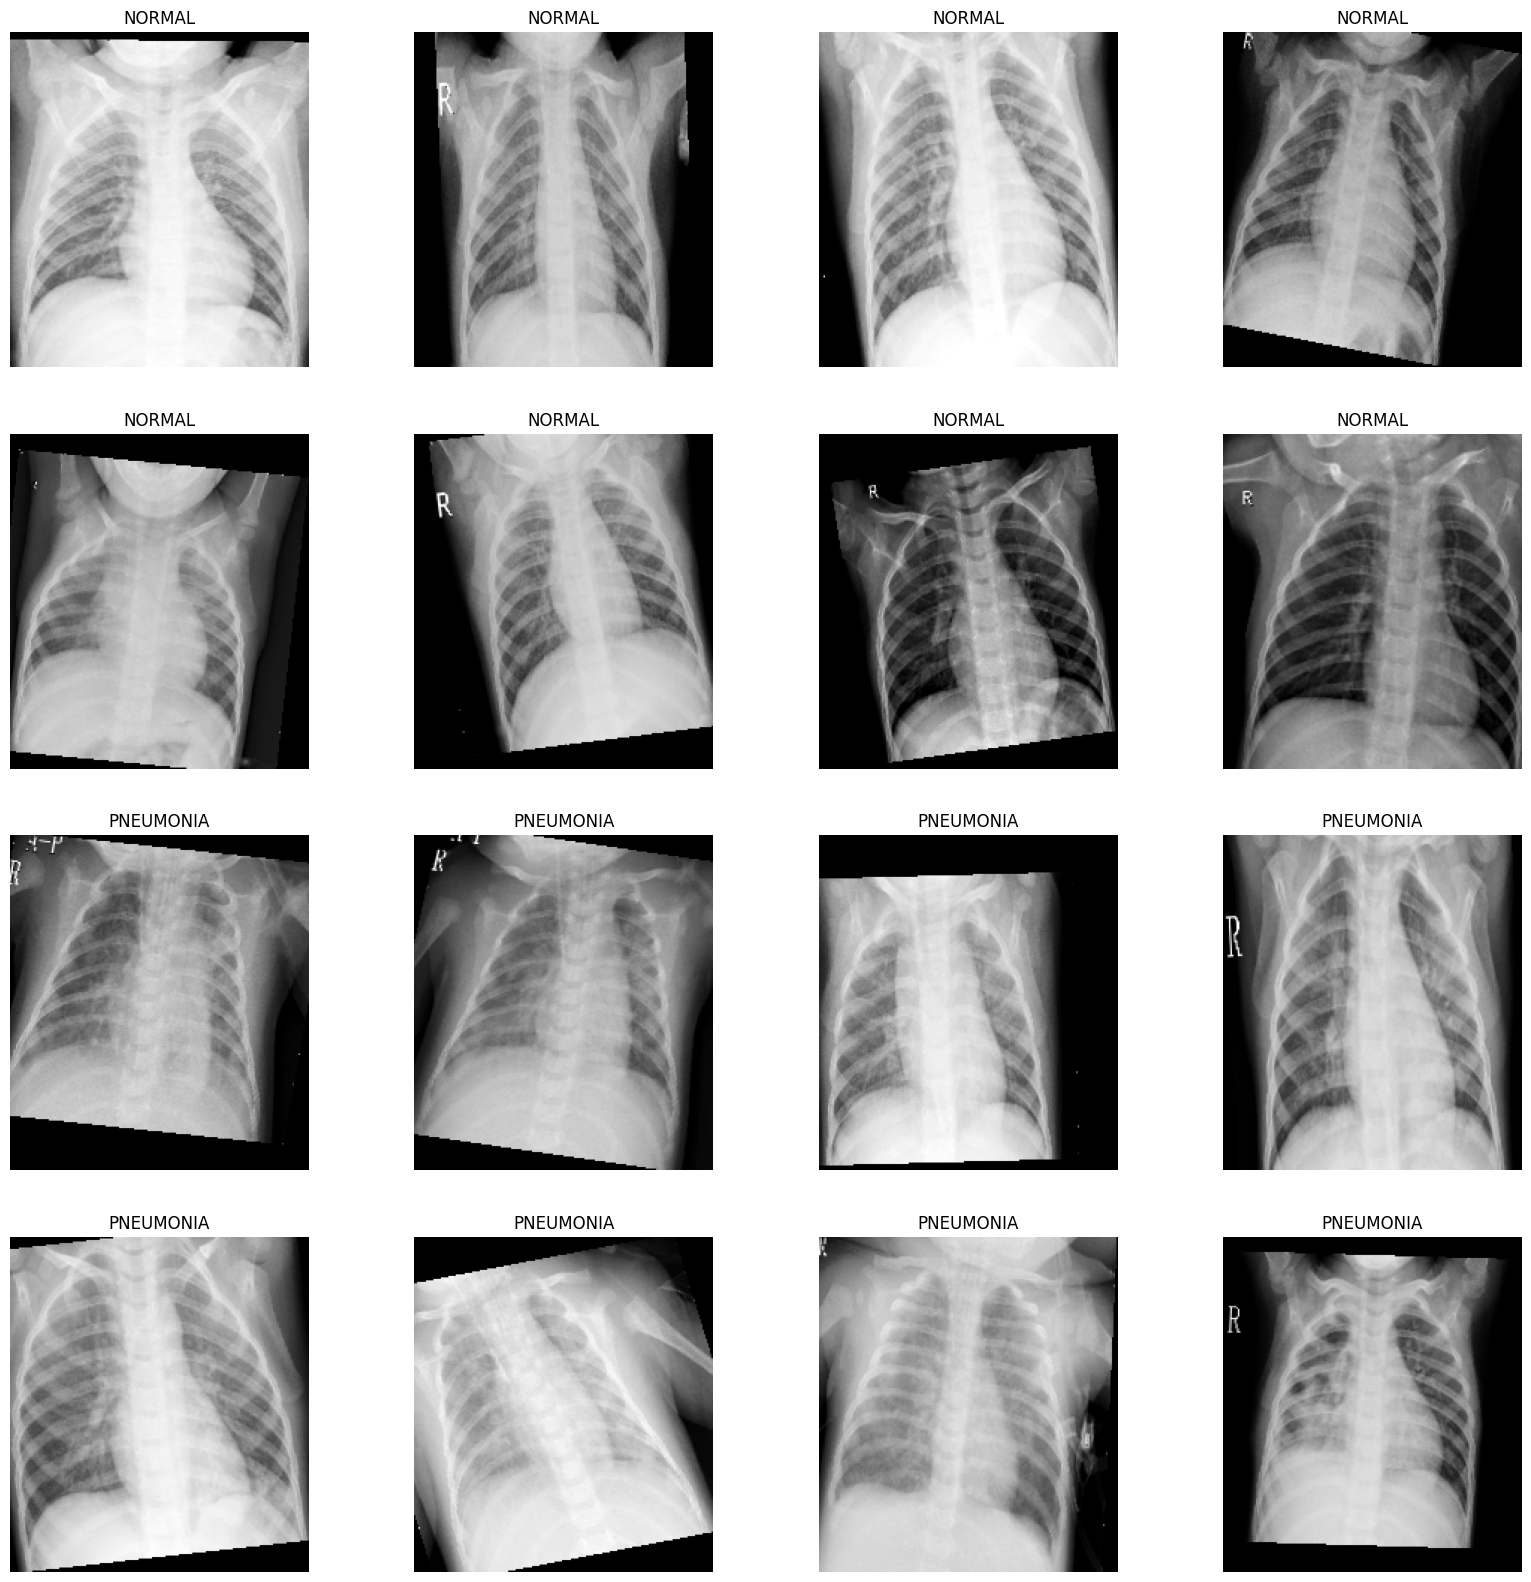

In [55]:


tiny_example = rescale_and_augment().flow_from_directory(
    os.path.join(base_path, 'val'),  # this folder contains 16 images
    target_size=IMAGE_DIMENSIONS,
    batch_size=16,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,
)

images, labels = next(tiny_example)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i], cmap='gray')
    label = int(labels[i])
    plt.title(classes[label])
    plt.axis('off')

plt.show()



In [56]:
from tensorflow.keras.layers import *


# all layers until the final single-neuron collapse
embedding_model = Sequential([
    
    Input([*IMAGE_DIMENSIONS, 1]),
    
    Conv2D(32, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    Conv2D(32, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    Conv2D(64, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    Conv2D(128, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(256, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    Conv2D(256, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    Conv2D(256, (3, 3), padding='valid', activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='sigmoid'),
])

model = Sequential([
    embedding_model,
    
    Dropout(0.5),
        
    Dense(1, activation='sigmoid'),
])

In [57]:
if tf.config.list_physical_devices('GPU'):
    print("Using GPU :)")
else:
    print("No GPU :/")

No GPU :/


In [58]:
from tensorflow.keras.callbacks import *

# reduce learning rate if no improvement for this many epochos
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=True, 
    mode='min', 
    min_delta=1e-4, 
    cooldown=2, 
    min_lr=1e-6,
)

# save best weights to a file
model_checkpoint = ModelCheckpoint(
    filepath='model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=True,
)

# stop training if no improvement for this many epochos
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=True,
    restore_best_weights=True
)


In [62]:

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#LOADING WEIGHTS

model.load_weights("model.keras")
#history = model.fit(
#    train_data,
#    steps_per_epoch=batch_steps(train_df),
#    epochs=50,
#    validation_data=validation_data,
#    validation_steps=batch_steps(val_df),
#    callbacks=[reduce_lr_on_plateau, model_checkpoint, early_stopping],
#)

/home/ilboglions/anaconda3/envs/JupyterEnv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [64]:
test_loss, test_acc = model.evaluate(test_data, steps=batch_steps(test_df), verbose=False)

print(f"""Test Accuracy: {test_acc * 100 : .2f}%""")

Test Accuracy:  88.94%


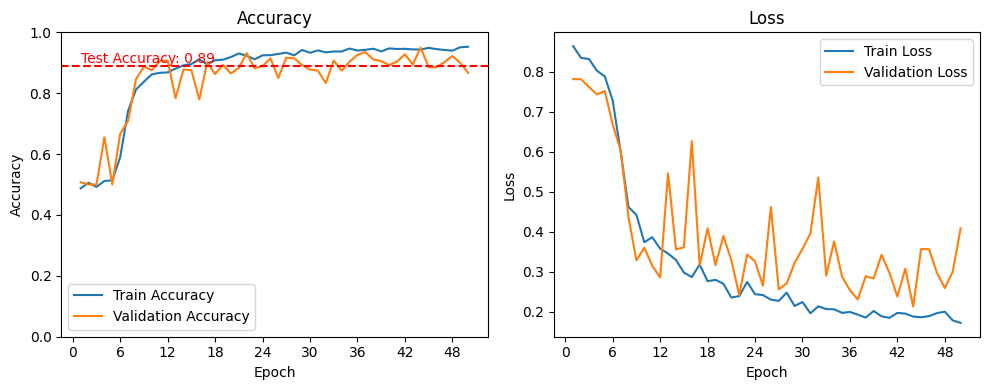

In [65]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Calculate new x-axis values (starting from 1)
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot training & validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.axhline(y=test_acc, color='r', linestyle='--')
plt.text(1, test_acc, f'Test Accuracy: {test_acc:.2f}', color='r', va='bottom')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()